#🎧 **MusicGen Audio Restoration  with DSP: Reducing Noise,Preserving Musicality** : 🎹


- **Obiettivo progetto** ⚡

Questo progetto ha come obiettivo la generazione di clip musicali con MusicGen a partire da prompt testuali, seguita dal miglioramento della qualità dell'audio tramite tecniche di audio restoration.
Il focus è la pulizia sonora (riduzione dei fruscii presenti) mantenendo il timbro originale.


- **Fasi iniziali progetto**

Nella prima parte del progetto mi occupo di:

- Installare le librerie necessarie per lavorare con modelli pre-addestrati.

- Caricare MusicGen (facebook/musicgen-small) da Hugging Face e generare 5 clip dai prompt.

- Organizzare i file .wav (16 kHz) per le fasi di restauro e valutazione.
- Set di metriche oggettive comuni a tutti i metodi

Nel progetto ho sviluppato e confrontato **tre modelli DSP** per la riduzione del fruscio tipico delle tracce MusicGen.
Si tratta di approcci differenti (basati su metodi di elaborazione spettrale), ma con lo stesso obiettivo:
migliorare la qualità sonora riducendo l’hiss senza alterare il timbro originale.





**Installo i pacchetti** 📥

In [67]:
!pip -q install noisereduce librosa soundfile pandas scipy pyloudnorm transformers accelerate

**Importo le librerie necessarie e costanti** 📕

In [68]:
# librerie
import os,glob,shutil,subprocess,random
import numpy as np, pandas as pd
import librosa , soundfile as sf , matplotlib.pyplot as plt
from scipy.signal import butter,sosfiltfilt
from IPython.display import Audio,display
import noisereduce as nr
from transformers import MusicgenForConditionalGeneration, AutoProcessor
import torch
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

**📥 Clonazione del repository GitHub del progetto e sincronizzazione dei file LFS**

Per lavorare sempre sulle stesse tracce audio senza doverle rigenerare ogni volta, ho deciso di mantenere i file .wav direttamente nel mio repository GitHub. Dal momento che questi file sono piuttosto pesanti, li gestisco tramite Git LFS (Large File Storage), un’estensione di Git che salva nel repo soltanto un puntatore al file, mentre il contenuto vero e proprio rimane in una memoria esterna. In questo modo il mio repository resta leggero e, quando ne ho bisogno, con il comando git lfs pull scarico in locale i file reali pronti per l’uso.

In [69]:
#clono repo GitHub del progetto e sincronizza file LFS
repo_user="giorgiacecchi"
repo_name="musicgen-restoration"
repo_dir=f"/content/{repo_name}"

if not os.path.exists(".git"):
  subprocess.run(["git","clone",f"https://github.com/{repo_user}/{repo_name}.git"], check=True)
  os.chdir(repo_name)
  print("cd nel repo:", os.getcwd())
else:
  if os.path.isdir(repo_dir):
    os.chdir(repo_dir)
    print("cd nel repo:", os.getcwd())


subprocess.run(["git","lfs","install"], check=False)
subprocess.run(["git","lfs","pull"], check=False)

cd nel repo: /content/musicgen-restoration


CompletedProcess(args=['git', 'lfs', 'pull'], returncode=0)

In [70]:
# Bootstrap: assicura che i 5 file WAV del repo siano presenti
raw_dir="outputs/raw"
os.makedirs(raw_dir, exist_ok=True)

files=sorted(glob.glob(f"{raw_dir}/track_*.wav"))
print("trovati", len(files), "wav in", raw_dir)

for fp in files:
    info=sf.info(fp)
    print(os.path.basename(fp), f"{info.duration:.2f}s", f"{info.samplerate}Hz")

if len(files)!=5:
  raise RuntimeError("Mancano i 5 WAV nel repo:senza di quelli non rigenero.Aggiungili prima al repo.")

trovati 5 wav in outputs/raw
track_1.wav 10.18s 16000Hz
track_2.wav 10.18s 16000Hz
track_3.wav 10.18s 16000Hz
track_4.wav 10.18s 16000Hz
track_5.wav 10.18s 16000Hz


**Caricamento del modello di MusicGen 🎹**

In [71]:
#Carico il modello MusicGen(small) e il relativo processo
model=MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")
processor=AutoProcessor.from_pretrained("facebook/musicgen-small")

Selezione del tipo di device 📔

In [72]:
device="cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

MusicgenForConditionalGeneration(
  (text_encoder): T5EncoderModel(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): L

**🎼Ora proviamo a generare la musica da un prompt**

✅ Obiettivo:

Fornisco in input una frase descrittiva ("prompt") e ottengo in output un file  .wav di musica generata dal modello MusicGen(small).

Passi fatti:
1. creo la cartella "outputs/";
2. per ogni prompt:
- preparo gli input
- genero un suono di circa 10 sec
- salvo il .wav n outputs/track_i.wav
- riproduco il suono


In [73]:
# cartelle risultati + SR
in_dir="outputs/raw"
out_base="outputs/processed"
met_dir="outputs/results"
sr=16000

os.makedirs(out_base,exist_ok=True)
os.makedirs(met_dir,exist_ok=True)

In [74]:
freeze=True    # True=usa WAV già presenti; False=genera dai prompt
regen=False    # True=rigenera anche se il file esiste
sr_out=16000   # sample rate di output

prompts=[
    "a relaxing lo-fi beat for studying",
    "a classical piano piece in a romantic style",
    "an upbeat jazz quartet with saxophone",
    "a cinematic orchestral theme",
    "ambient meditation music with soft pads"
]

def set_seed(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

def to_mono(y):
    if y.ndim==2:
        return np.mean(y,axis=0)
    return y

def resample_to(y,sr_in,sr_out):
    if sr_in==sr_out:
        return y
    return librosa.resample(y.astype(np.float32), orig_sr=sr_in, target_sr=sr_out)

os.makedirs(raw_dir,exist_ok=True)

sr_model=getattr(processor,"sampling_rate",32000)

print("FREEZE=",freeze,"| REGEN=",regen)
print("sr_model=",sr_model,"| sr_out=",sr_out)

if freeze:
    print("freeze=True → uso i WAV già nel repo, nessuna rigenerazione.")
    for fp in sorted(glob.glob(f"{raw_dir}/track_*.wav")):
        display(Audio(fp,rate=sr_out))
else:
    seed=1234
    tokens=512
    for i,prompt in enumerate(prompts,start=1):
        path=f"{raw_dir}/track_{i}.wav"
        print(f"traccia {i} | {prompt}")

        if os.path.exists(path) and not regen:
            print("esiste già, skip:",path)
            display(Audio(path,rate=sr_out))
            print("-"*50)
            continue

        inputs=processor(text=[prompt],return_tensors="pt").to(device)
        set_seed(seed+i)
        gen=torch.Generator(device=device).manual_seed(seed+i)

        with torch.inference_mode():
            audio_values=model.generate(
                **inputs,
                max_new_tokens=tokens,
                do_sample=True,
                generator=gen
            )

        wav=audio_values[0].detach().cpu().numpy()
        wav=to_mono(wav)
        wav=resample_to(wav,sr_in=sr_model,sr_out=sr_out)

        peak=np.max(np.abs(wav))+1e-12
        if peak>1.0:
            wav=wav/peak

        sf.write(path,wav.astype(np.float32),sr_out)
        print("salvata:",path)
        display(Audio(path,rate=sr_out))
        print("-"*50)


FREEZE= True | REGEN= False
sr_model= 32000 | sr_out= 16000
freeze=True → uso i WAV già nel repo, nessuna rigenerazione.


**Metriche comuni** utilizzate per valutare il suono restaurato


In [75]:
def hf_band_energy_db(y,sr,low=6000):
    S=np.abs(librosa.stft(y,n_fft=2048,hop_length=512))**2
    freqs=librosa.fft_frequencies(sr=sr,n_fft=2048)
    val=S[freqs>=low].sum()+1e-12
    return 10*np.log10(val)

def hpss_ratio(y):
    H,P=librosa.decompose.hpss(librosa.stft(y))
    h=np.sum(np.abs(H)**2); p=np.sum(np.abs(P)**2)+1e-12
    return float(h/p)

def log_mel_distance(y_ref,y_proc,sr,n_mels=64):
    def _mel(y_audio):
        M=librosa.feature.melspectrogram(y=y_audio,sr=sr,n_mels=n_mels,n_fft=2048,hop_length=512,power=2.0)
        return np.log(M+1e-9)
    A=_mel(y_ref)
    B=_mel(y_proc)
    m=min(A.shape[1],B.shape[1])
    return float(np.mean(np.abs(A[:,:m]-B[:,:m])))



**Plot generico** da applicare ad ogni modello

In [76]:
# soglia per la Log-Mel distance
TH_LOGMEL = 0.20
def plot_metric(df,column,title,ylabel,hline=0.0):
    values=df.set_index("track")[column]
    tracks=values.index
    #Se la metrica è la Log-Mel distance → usa la soglia dedicata
    if "log_mel" in column.lower():
        hline = TH_LOGMEL
        # verde se sotto soglia (=buono), rosso se sopra (=alterazione timbrica)
        colors = ["#4CAF50" if v < hline else "#F44336" for v in values]
    else:
        # default: verde se sopra la linea, rosso se sotto
        colors = ["#4CAF50" if v >= hline else "#F44336" for v in values]

    plt.figure(figsize=(8,4))
    bars=plt.bar(tracks,values,color=colors)
    plt.axhline(hline,color="black",linestyle="--",linewidth=1)

    for bar,val in zip(bars,values):
        y=val+(0.04*abs(values.max()) if val>=hline else -0.06*abs(values.max()))
        va="bottom" if val>=hline else "top"
        plt.text(bar.get_x()+bar.get_width()/2,y,f"{val:.3f}",ha="center",va=va,fontsize=9)

    plt.title(title,fontsize=13,fontweight="bold")
    plt.ylabel(ylabel)
    plt.xlabel("Traccia")
    plt.grid(axis="y",linestyle="--",alpha=0.6)
    plt.tight_layout()
    plt.show()

**Runner comune** (genera tabella, salva csv e wav)

In [77]:
def applico_e_confronto(method_name,process_fn,preview_n=5,play_raw=True):
    rows=[]

    files=sorted(glob.glob(os.path.join(in_dir,"*.wav")))
    assert files,"nessun .wav trovato in in_dir"

    out_dir=os.path.join(out_base,method_name)
    os.makedirs(out_dir,exist_ok=True)

    for i,fp in enumerate(files,1):
        name=os.path.splitext(os.path.basename(fp))[0]
        y,_=librosa.load(fp,sr=sr,mono=True)

        #BEFORE
        b_hfdb=hf_band_energy_db(y,sr,6000)
        b_hpss=hpss_ratio(y)

        #PROCESS
        yp=process_fn(y,sr)

        #AFTER
        a_hfdb=hf_band_energy_db(yp,sr,6000)
        a_hpss=hpss_ratio(yp)
        lmd=log_mel_distance(y,yp,sr)

        #DELTA
        d_hfdb=a_hfdb-b_hfdb  #<0 meglio
        d_hpss=a_hpss-b_hpss  #>=0 meglio

        #Criteri (2 su 3 per OK)
        ok_hf=d_hfdb<0.0
        ok_hpss=d_hpss>=0.0
        ok_lmd=lmd<=TH_LOGMEL

        ok_count=int(ok_hf)+int(ok_hpss)+int(ok_lmd)
        criteri_ok=f"{ok_count}/3"
        verdict="OK" if ok_count>=2 else "NO"

        rows.append({
            "track":name,
            "before_hf_band_db":b_hfdb,"after_hf_band_db":a_hfdb,"delta_hf_band_db":d_hfdb,
            "before_hpss_ratio":b_hpss,"after_hpss_ratio":a_hpss,"delta_hpss_ratio":d_hpss,
            "log_mel_distance":lmd,
            "OK_HFband":ok_hf,"OK_HPSS":ok_hpss,"OK_LogMel":ok_lmd,
            "OK_count":ok_count,"criteri_ok":criteri_ok,"Verdetto":verdict
        })

        if i<=preview_n:
            print(f"\n{name} — {method_name}")
            if play_raw:
                print("RAW"); display(Audio(y,rate=sr))
            print("PROC"); display(Audio(yp,rate=sr))

        sf.write(os.path.join(out_dir,f"{name}_{method_name}.wav"),yp,sr)

    df=pd.DataFrame(rows)

    order=[
        "track",
        "before_hf_band_db","after_hf_band_db","delta_hf_band_db",
        "before_hpss_ratio","after_hpss_ratio","delta_hpss_ratio",
        "log_mel_distance",
        "OK_HFband","OK_HPSS","OK_LogMel","OK_count","criteri_ok","Verdetto"
    ]
    df=df[order]

    num_cols=[
        "before_hf_band_db","after_hf_band_db","delta_hf_band_db",
        "before_hpss_ratio","after_hpss_ratio","delta_hpss_ratio",
        "log_mel_distance"
    ]
    for c in num_cols:
        df[c]=df[c].astype(float).round(3)

    display(df)

    passed=(df["Verdetto"]=="OK").sum()
    print(f"\nRIEPILOGO: tracce OK={passed}/{len(df)}")

    csv_path=os.path.join(met_dir,f"results_{method_name}.csv")
    df.to_csv(csv_path,index=False)
    print("Tabella salvata in:",csv_path,"| WAV in:",out_dir)

    return df


#Scelta dei modelli 💠


#**Modello 1**:  

**NoiseReduce (DSP su alte frequenze)**

Questo modello agisce in modo mirato sulla banda alta (≥ 6 kHz), dove è più evidente il fruscio generato da MusicGen.  
La strategia che ho seguito è composta da tre passaggi:

1. **Filtro passa-alto** per isolare solo le frequenze superiori a 6 kHz.  
2. **NoiseReduce stazionario** applicato esclusivamente su questa banda per attenuare l’hiss.  
3. **Ricombinazione** della parte filtrata con il resto del segnale originale, così da preservare il corpo e il timbro musicale.

In questo modo la riduzione del rumore risulta efficace e mirata, senza modificare la struttura armonica né il carattere complessivo del brano.




track_1 — m1_nr_alte
RAW


PROC



track_2 — m1_nr_alte
RAW


PROC



track_3 — m1_nr_alte
RAW


PROC



track_4 — m1_nr_alte
RAW


PROC



track_5 — m1_nr_alte
RAW


PROC


track  before_hf_band_db  after_hf_band_db  delta_hf_band_db  \
0  track_1             35.113            34.301            -0.812   
1  track_2             -1.968            -5.409            -3.441   
2  track_3             30.753            24.000            -6.752   
3  track_4             25.169            18.588            -6.581   
4  track_5             -7.487            -9.768            -2.281   

   before_hpss_ratio  after_hpss_ratio  delta_hpss_ratio  log_mel_distance  \
0              5.322             5.326             0.003             0.168   
1            105.813           105.814             0.001             0.169   
2             12.364            12.464             0.100             0.177   
3            143.980           144.094             0.114             0.179   
4             92.600            92.600             0.000             0.174   

   OK_HFband  OK_HPSS  OK_LogMel  OK_count criteri_ok Verdetto  
0       True     True       True         3        3/3       OK  
1       True     True       True         3        3/3       OK  
2       True     True       True         3        3/3       OK  
3       True     True       True         3        3/3       OK  
4       True     True       True         3        3/3       OK


RIEPILOGO: tracce OK=5/5
Tabella salvata in: outputs/results/results_m1_nr_alte.csv | WAV in: outputs/processed/m1_nr_alte


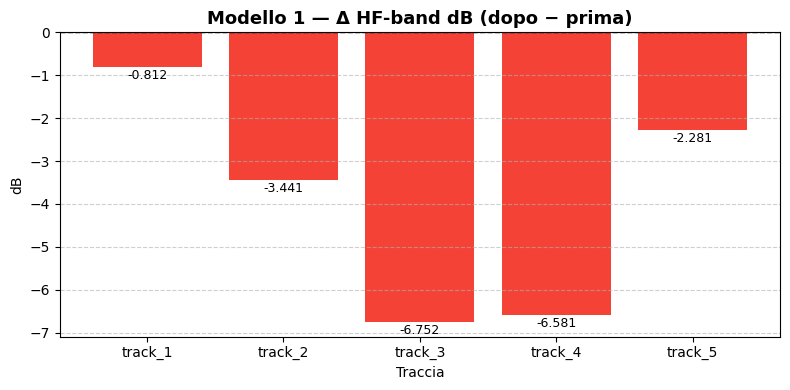

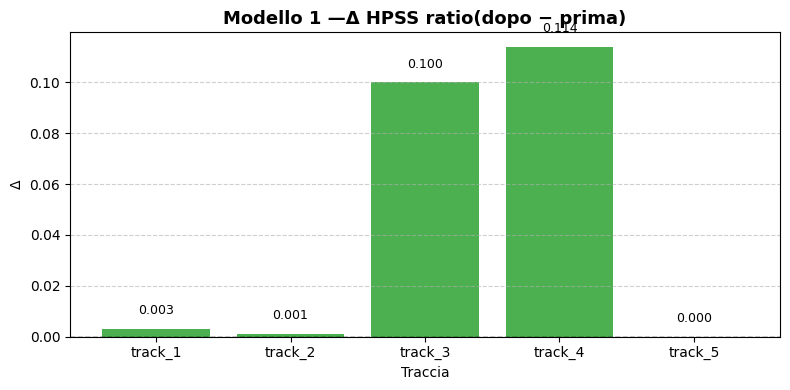

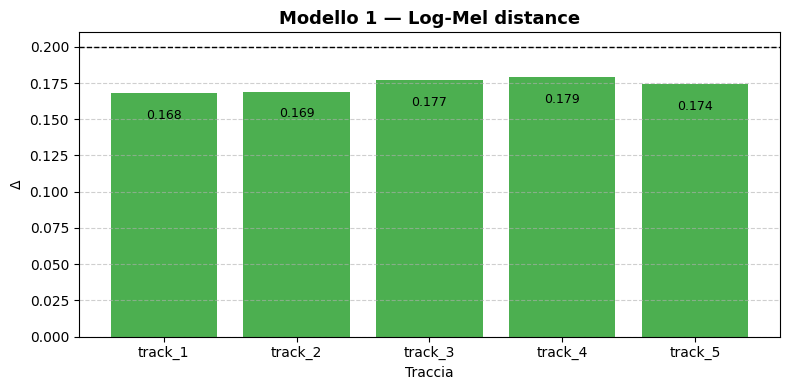

In [78]:
def highpass(y,sr,fc=6000,order=6):
  #creo un filtro passa-alto 8cutogg=6) e lo applico al segnale
  sos=butter(order,fc/(sr/2),btype="highpass",output="sos")
  return sosfiltfilt(sos,y)

def denoise_nr_alte(y,sr):
  #isolo solo alte frequenze
  y_hi=highpass(y,sr,fc=6000,order=6)
  #faccio denoising solo sulla banda alta
  y_hi_dn=nr.reduce_noise(y=y_hi,sr=sr,stationary=True,prop_decrease=0.7,
                            time_constant_s=1.0,freq_mask_smooth_hz=600)
  #ricompongo: (originale-alte sporche)+alte denoised
  y_out=y-y_hi+y_hi_dn
  mx=np.max(np.abs(y_out))+1e-12
  #anti-clip il quale impedisce al suono di diventare troppo forte o distorto
  if mx>0.99:
    y_out=0.99*y_out/mx
  return y_out

#tabella + grafici
df_nr=applico_e_confronto("m1_nr_alte",denoise_nr_alte,preview_n=5,play_raw=True)
df_nr
plot_metric(df_nr, "delta_hf_band_db", "Modello 1 — Δ HF-band dB (dopo − prima)", "dB", hline=0.0)
plot_metric(df_nr, "delta_hpss_ratio", "Modello 1 —Δ HPSS ratio(dopo − prima)", "Δ", hline=0.0)
plot_metric(df_nr, "log_mel_distance", "Modello 1 — Log-Mel distance", "Δ", hline=TH_LOGMEL)

#**Modello 2**:

**High-Band Spectral Subtraction (HB-SS)⏸▶**

Il secondo modello utilizza la sottrazione spettrale, ma limitata soltanto alla banda alta (≥ 6 kHz).
L’idea è ridurre il rumore stazionario dove si concentra il fruscio, evitando di alterare le frequenze medio-basse che contengono le armoniche principali.

I parametri chiave sono:

α (oversubtraction) per aumentare la rimozione del rumore,

β (spectral floor) per prevenire il musical noise (artefatti metallici).

È un approccio più semplice e controllato: meno aggressivo dell’MCRA fullband, ma anche meno stabile rispetto al NoiseReduce mirato.

In [ ]:
def denoise_hbss_alte(
    y, sr,
    f_cut=6000,
    n_fft=2048,
    hop_length=512,
    alpha=1.4,      #fattore di oversubtraction
    beta=0.06,      # soglia minima  spettrale
    noise_pct=0.20, # % frame più "silenziosi" per stimare N(k)
    min_quiet_sec=0.5):

    #trasformata di Fourier a breve termine (STFT)
    S=librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    mag=np.abs(S)
    phase=np.angle(S)

    #seleziono la banda alta
    freqs=librosa.fft_frequencies(sr=sr,n_fft=n_fft)
    hi=freqs>=f_cut

    #individuo i frame "silenziosi"
    frame_rms=librosa.feature.rms(S=S).flatten()
    T=mag.shape[1]
    n_quiet=max(1,int(noise_pct*T))
    quiet_idx=np.argsort(frame_rms)[:n_quiet]

    #se i frame silenziosi non bastano, uso i primi min_quiet_sec secondi
    fallback_frames=int(np.ceil(min_quiet_sec*sr/hop_length))
    if fallback_frames>0:
        quiet_idx=np.unique(np.concatenate([quiet_idx,np.arange(min(T,fallback_frames))]))

    #mediana sui frame silenziosi
    noise_profile=np.median(mag[:, quiet_idx], axis=1)

    #applico la sottrazione spettrale solo in banda alta
    mag_clean=mag.copy()
    mag_clean[hi,:]=np.maximum(
        mag[hi,:]-alpha*noise_profile[hi,np.newaxis],
        beta*mag[hi,:]
    )

    #ricostruisco il segnale con fase originale
    S_clean=mag_clean*np.exp(1j*phase)
    y_clean=librosa.istft(S_clean,hop_length=hop_length,window='hann',length=len(y))

    #anti-clip
    peak=np.max(np.abs(y_clean))+1e-12
    if peak>0.99:
        y_clean=0.99*y_clean/peak

    return y_clean

#tabella + grafici
df_hbss = applico_e_confronto("m2_hbss_alte", denoise_hbss_alte, preview_n=5, play_raw=True)

#1)Δ HF-band dB (più negativo = meglio  è)
plot_metric(df_hbss, "delta_hf_band_db",
            "Modello 2 — Δ HF-band dB (dopo − prima)", "dB", hline=0.0)

# 2) Δ HPSS ratio (≥ 0 = meglio)
plot_metric(df_hbss, "delta_hpss_ratio",
            "Modello 2 — Δ HPSS ratio (dopo − prima)", "Δ", hline=0.0)

# 3) Log-Mel distance (più basso = meglio)
plot_metric(df_hbss, "log_mel_distance",
            "Modello 2 — Log-Mel distance", "Δ", hline=TH_LOGMEL)

#**Modello 3**:

**MCRA + filtro HF “safe” ⏸▶**

Questo modello interviene su tutto lo spettro, stimando dinamicamente il rumore con l’algoritmo MCRA (Minimum Controlled Recursive Averaging), che “impara” il livello di rumore osservando i momenti più silenziosi del segnale. Successivamente applica un guadagno in stile Wiener, che attenua le frequenze rumorose preservando quelle utili.

È l’approccio più aggressivo: riesce a ridurre in modo marcato il fruscio, soprattutto alle alte frequenze, ma introduce un maggiore rischio di alterazioni timbriche rispetto agli altri modelli.

In [ ]:
def denoise_mcra_hf(y_np,sr,
                    n_fft=2048,hop=512,f_cut=6000,
                    alpha_n=0.98,kappa=1.25,
                    alpha_gain=1.20,g_floor=0.055,
                    fullband_mix=0.25,hf_boost=1.015,
                    smooth_att=0.90,smooth_rel=0.75):
    eps=1e-10
    y=np.asarray(y_np,dtype=np.float32)
    #se l'audio ha due canali(stereo),lo trasformiamo in uno solo (mono)
    if y.ndim==2:
        if y.shape[0]<=8 and y.shape[0]<y.shape[1]:
            y=y.mean(axis=0)
        else:
            y=y.mean(axis=1)
    #ShortTimeFourierTrasform
    s=librosa.stft(y,n_fft=n_fft,hop_length=hop,window="hann",center=True)
    mag=np.abs(s)+eps
    phase=np.exp(1j*np.angle(s))
    p=mag**2
    f_bins,t_frames=mag.shape
    #maschera per distinguere alte frequenze
    freqs=librosa.fft_frequencies(sr=sr,n_fft=n_fft)
    mask_hf=freqs>=f_cut
    #inizializzo stime rumore
    n_est=p[:,0:1].copy()
    m_track=p[:,0:1].copy()

    mag_clean=np.empty_like(mag)
    g_prev=np.ones((f_bins,1),dtype=np.float32)

    # limite di variazione del gain tra frame
    dg_max_hf=0.10  # 10% alle alte frequenze
    dg_max_lf=0.20  # 20% alle basse frequenze

    #ciclo su ogni frame
    for t in range(t_frames):
        y_psd=p[:,t:t+1]

        #stima del rumore secondo MCRA
        n_est=alpha_n*n_est+(1.0-alpha_n)*y_psd
        m_track=np.minimum(kappa*m_track,y_psd)
        n_hat=np.maximum(n_est,m_track)
        #guadagno di Wiener
        snr=y_psd/(n_hat+eps)
        g_cur=snr/(snr+alpha_gain)
        g_cur=np.clip(g_cur,g_floor,1.0)

        #smoothing attacco/rilascio
        down=g_cur<g_prev
        g_s=g_prev.copy()
        g_s[down]=smooth_att*g_prev[down]+(1.0-smooth_att)*g_cur[down]
        g_s[~down]=smooth_rel*g_prev[~down]+(1.0-smooth_rel)*g_cur[~down]

        #limiti per High frequencies e Low frequencies
        if np.any(mask_hf):
            g_hf=g_s[mask_hf,:]
            g_prev_hf=g_prev[mask_hf,:]
            g_hf=np.clip(g_hf,g_prev_hf*(1.0-dg_max_hf),g_prev_hf*(1.0+dg_max_hf))
            g_s[mask_hf,:]=g_hf
        if np.any(~mask_hf):
            g_lf=g_s[~mask_hf,:]
            g_prev_lf=g_prev[~mask_hf,:]
            g_lf=np.clip(g_lf,g_prev_lf*(1.0-dg_max_lf),g_prev_lf*(1.0+dg_max_lf))
            g_s[~mask_hf,:]=g_lf

        g_prev=g_s

        #applico guadagno alle  High frequencies
        g_apply=np.ones_like(g_s)
        if np.any(mask_hf):
            g_apply[mask_hf,:]=g_s[mask_hf,:]
        if np.any(~mask_hf):
            g_apply[~mask_hf,:]=1.0-(1.0-g_s[~mask_hf,:])*fullband_mix

        mag_clean[:,t:t+1]=mag[:,t:t+1]*g_apply

    if hf_boost!=1.0 and np.any(mask_hf):
        mag_clean[mask_hf,:]=mag_clean[mask_hf,:]*hf_boost

    #ricostruisco segnale
    s_clean=mag_clean*phase
    y_out=librosa.istft(s_clean,hop_length=hop,length=len(y))
    peak=np.max(np.abs(y_out))+eps
    #Aanti-clip
    if peak>0.999:
        y_out=y_out*(0.999/peak)
    return y_out.astype(np.float32)

#tabella + grafici
df_m3 = applico_e_confronto("m3_mcra_hf", denoise_mcra_hf, preview_n=5, play_raw=True)

# 1) Δ HF-band dB (più negativo = meglio)
plot_metric(df_m3, "delta_hf_band_db",
            "Modello 3 — Δ HF-band dB (dopo − prima)", "dB", hline=0.0)

# 2) Δ HPSS ratio (≥ 0 = meglio)
plot_metric(df_m3, "delta_hpss_ratio",
            "Modello 3 — Δ HPSS ratio (dopo − prima)", "Δ", hline=0.0)

# 3) Log-Mel distance (più basso = meglio; baseline fissata in TH_LOGMEL)
plot_metric(df_m3, "log_mel_distance",
            "Modello 3 — Log-Mel distance", "Δ", hline=TH_LOGMEL)

#**Grafico finale** 🕜

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

CSV_M1="outputs/results/results_m1_nr_alte.csv"
CSV_M2="outputs/results/results_m2_hbss_alte.csv"
CSV_M3="outputs/results/results_m3_mcra_hf.csv"

def load_df(path,model):
    df=pd.read_csv(path)
    df=df.rename(columns={c:c.strip() for c in df.columns})
    df["model"]=model
    return df[["model","track","OK_HFband","OK_HPSS","OK_LogMel","OK_count","criteri_ok"]]

m1=load_df(CSV_M1,"M1_NR")
m2=load_df(CSV_M2,"M2_HBSS")
m3=load_df(CSV_M3,"M3_MCRA")
all_df=pd.concat([m1,m2,m3],ignore_index=True)

# score ufficiale=% tracce con 3/3 OK
by=all_df.groupby("model",as_index=True)
score=(by.apply(lambda g:(g["OK_count"]==3).mean()*100)).to_frame("score")

# breakdown per metrica=% tracce OK per ciascun criterio
score["HF_ok%"]=by["OK_HFband"].mean()*100
score["HPSS_ok%"]=by["OK_HPSS"].mean()*100
score["LogMel_ok%"]=by["OK_LogMel"].mean()*100

# ordino per score
score=score.sort_values("score")

# grafico A: solo score (classifica)
#La traccia conta solo se sono tutti True contemporaneamente.
#(OK_HFband, OK_HPSS, OK_LogMel)
#se anche un solo criterio è False per tutte le tracce (es.OK_LogMel sempre
#False in M3), nessuna traccia raggiunge 3/3 quindi 0%
plt.figure(figsize=(7.5,3.2))
bars=plt.barh(score.index,score["score"],height=0.6)
for b,v in zip(bars,score["score"]):
    plt.text(b.get_width()+1,b.get_y()+b.get_height()/2,f"{v:.1f}%",va="center",fontsize=11,fontweight="bold")
plt.title("Score ufficiale: % tracce con 3/3 criteri OK")
plt.xlabel("percentuale")
plt.xlim(0,100)
plt.grid(axis="x",linestyle="--",alpha=0.35)
plt.tight_layout()
plt.show()

# grafico B: breakdown dei criteri (impilato, somma non=100 perché criteri indipendenti)
cols=["HF_ok%","HPSS_ok%","LogMel_ok%"]
colors={"HF_ok%":"royalblue","HPSS_ok%":"seagreen","LogMel_ok%":"darkorange"}
plt.figure(figsize=(9,4))
left=[0]*len(score)
for c in cols:
    vals=score[c].values
    plt.barh(score.index,vals,left=left,height=0.6,color=colors[c],edgecolor="white")
    left=[l+v for l,v in zip(left,vals)]
# legenda
handles=[Patch(facecolor=colors[c],label=c.replace("_ok%","").replace("_"," ")+ " (OK%)") for c in cols]
plt.legend(handles=handles,loc="lower right")
plt.title("Affidabilità per criterio: % tracce OK")
plt.xlabel("percentuale")
plt.xlim(0,300)  # 3 criteri max → 300%
plt.grid(axis="x",linestyle="--",alpha=0.35)
plt.tight_layout()
plt.show()

# tabella finale da mettere in relazione
print(score.round(1))


## Analisi finale e Conclusione

Il **primo grafico** mostra la percentuale di tracce che superano **tutti e 3 i criteri** contemporaneamente:  
- M1_NR raggiunge il 100% (tutte le tracce con 3/3 OK),  
- M2_HBSS solo il 40% (tutti criteri rispettati solo in 2 tracce su 5 -> quindi 2/5=40%),  
- M3_MCRA 0% (nessuna traccia rispetta tutti i criteri insieme, nessuno rispetta la log mel distance ).  

Il **secondo grafico** scompone i criteri:

si osserva che tutti i modelli riducono il fruscio (HF OK) e preservano le armoniche (HPSS OK), ma la **Log-Mel distance** è il vero punto critico:  
- M1_NR resta sempre sotto soglia (100% OK),  
- M2_HBSS solo nel 40% dei casi,  
- M3_MCRA mai (5 fallimenti su 5).

### Conclusione breve
Dai risultati emerge che:
- **Modello 1 (NoiseReduce su HF)** è il più **affidabile e costante**.  
- **Modello 2 (HB-SS)** ha prestazioni **intermedie**, utile ma non sempre sufficiente.  
- **Modello 3 (MCRA fullband)** è il più **aggressivo**, ma fallisce sistematicamente sulla Log-Mel distance, risultando poco stabile nelle metriche, anche se all’ascolto può sembrare accettabile.

In sintesi: il primo modello è la scelta di riferimento, il secondo può essere utile in condizioni specifiche, mentre il terzo richiede attenzione.
